In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from thor_magni_tools.utils.load import load_csv_metadata_magni, preprocessing_header_magni
from thor_magni_tools.preprocessing.filtering import Filterer3DOF
from thor_magni_tools.io import load_json_file

In [2]:
os.listdir("datasets/thor_magni/CSVs_Scenarios/Scenario_3")

['THOR-Magni_180522_SC3B_R1.csv',
 'THOR-Magni_170522_SC3A_R1.csv',
 'THOR-Magni_170522_SC3A_R2.csv',
 'THOR-Magni_130522_SC3A_R1.csv',
 'THOR-Magni_180522_SC3A_R2.csv',
 'THOR-Magni_120522_SC3B_R2.csv',
 'THOR-Magni_170522_SC3B_R1.csv',
 'THOR-Magni_170522_SC3B_R2.csv',
 'THOR-Magni_130522_SC3B_R2.csv',
 'THOR-Magni_130522_SC3B_R1.csv',
 'THOR-Magni_180522_SC3A_R1.csv',
 'THOR-Magni_120522_SC3A_R1.csv',
 'THOR-Magni_120522_SC3B_R1.csv',
 'THOR-Magni_130522_SC3A_R2.csv',
 'THOR-Magni_180522_SC3B_R2.csv',
 'THOR-Magni_120522_SC3A_R2.csv']

In [3]:
DIR_PATH = "datasets/thor_magni/CSVs_Scenarios"
VISUALS_PATH = "datasets/thor_magni/maps/"

FILE_NAME = "THOR-Magni_170522_SC3B_R1.csv"

In [4]:
experiment_info = FILE_NAME.split("_")
date, scenario = experiment_info[1][:4], experiment_info[2]
month = "May" if date[2:] == "05" else "September"

scenario_map = scenario
if scenario in ["SC3A", "SC3B"]:
    scenario_map = "SC3"

In [5]:
raw_df, header_dict = load_csv_metadata_magni(
    os.path.join(DIR_PATH, f"Scenario_{scenario_map[2]}", FILE_NAME)
)

In [6]:
new_header_dict = preprocessing_header_magni(header_dict)
traj_metadata = new_header_dict["SENSOR_DATA"]["TRAJECTORIES"]["METADATA"]

### Filtering best markers

In [7]:
roles = {k: metadata["ROLE"] for k, metadata in traj_metadata.items()}
best_markers_traj = Filterer3DOF.filter_best_markers(raw_df, roles)

In [8]:
best_markers_traj[["x", "y"]] /= 1000 # to m

### Helper pix <-> m 

In [9]:
class PixWorldConverter:
    """Pixel to world converter"""

    def __init__(self, info: dict) -> None:
        self.resolution = info["resolution_pm"]  # 1pix -> m
        self.offset = np.array(info["offset"])

    def convert2pixels(self, world_locations: np.array) -> np.array:
        if world_locations.ndim == 2:
            return (world_locations / self.resolution) - self.offset

        new_world_locations = [
            self.convert2pixels(world_location) for world_location in world_locations
        ]
        return np.stack(new_world_locations)

    def convert2world(self, pix_locations: np.array) -> np.array:
        return (pix_locations + self.offset) * self.resolution

In [10]:
vis_path = (
    os.path.join(VISUALS_PATH, f"{date}_map.png")
    if scenario_map in ["SC4A", "SC4B", "SC5"]
    else os.path.join(VISUALS_PATH, f"{date}_{scenario_map}_map.png")
)

In [11]:
offsets = load_json_file(os.path.join(VISUALS_PATH, "offsets.json"))
info = {"resolution_pm" : 0.01, "offset": offsets[month]} 
pix2world_converter = PixWorldConverter(info)

In [12]:
img = Image.open(vis_path)
targ_img = np.array(img)
map_layout  = np.flipud(targ_img[:,:,:3])

# Plot trajectories

In [13]:
best_markers_traj = best_markers_traj.copy()
best_markers_traj.loc[:, ["x_px", "y_px"]] = pix2world_converter.convert2pixels(
    best_markers_traj[["x", "y"]].values
)

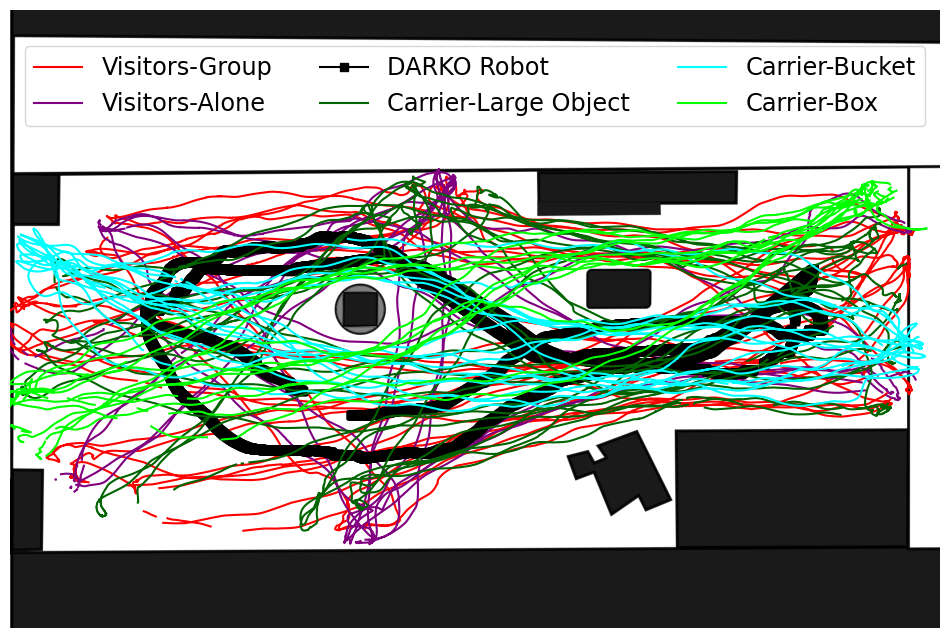

In [15]:
plt.figure(figsize=(12, 12))
plt.imshow(map_layout)
roles_count = {
    role: 0
    for role in [
        "Visitors-Alone",
        "Visitors-Group",
        "DARKO Robot",
        "Carrier-Large Object",
        "Carrier-Box",
        "Carrier-Bucket",
    ]
}
plot_mapping = {
    "Visitors-Group": "red",
    "Visitors-Alone": "purple",
    "Carrier-Large Object": "darkgreen",
    "Carrier-Box": "lime",
    "Carrier-Bucket": "cyan",
    "DARKO Robot": "black",
}
for role in sorted(best_markers_traj.agent_type.unique())[::-1]:
    traj_role = best_markers_traj[best_markers_traj["agent_type"] == role]
    for agent_id in traj_role["ag_id"].unique():
        traj_agent = traj_role[traj_role["ag_id"] == agent_id]
        role = roles[agent_id]

        if role in ["Differential-Teleoperated", "Omnidirectional-Teleoperated"]:
            role = "DARKO Robot"
        elif "Visitors-Group" in role:
            role = "Visitors-Group"
        elif "Carrier-Large Object" in role:
            role = "Carrier-Large Object"
        elif role == "Carried":
            continue
        roles_count[role] += 1
        
        plt.plot(
            traj_agent["x_px"],
            traj_agent["y_px"],
            color=plot_mapping[role],
            marker="s" if role == "DARKO Robot" else None,
            label=role if roles_count[role] == 1 else None,
    )
plt.axis("off")
plt.xlim([0, 1850])
plt.ylim([500, 1730])
plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 0.96), fontsize="xx-large")
plt.savefig("/home/tmr/Downloads/magni_scenario_3b.svg")